# Predicting tags on Stack Overflow's Python questions

## Problem definition

The goal of this model is to predict which tags beyond python
can be assigned to a given python question.

## Dataset used

The dataset used on this model comes from the official Stack Overflow contains only python
questions from 2015, that contains the title, body and assigned tags.

The query used to fetch the data can be accessed [here](https://data.stackexchange.com/stackoverflow/query/1317705).


### Below there's a overview of how the dataset looks

In [3]:
import pandas as pd


df = pd.read_csv("QueryResultsIsPandas.csv", sep=",")
df.head(3)

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,...,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense,isPandas
0,33054527,1,33054552.0,NaN,2015-10-10 13:28:09,NaN,648,1269290,<p>I've very recently migrated to Py 3.5.\nThi...,1656343.0,...,2020-09-12 09:40:46,"TypeError: a bytes-like object is required, no...",<python><python-3.x><string><file><byte>,9,4,101.0,NaN,NaN,CC BY-SA 4.0,0
1,29846087,1,NaN,NaN,2015-04-24 11:16:44,NaN,271,772140,<p>I've installed Python 3.5 and while running...,268598.0,...,2020-10-23 23:33:38,Microsoft Visual C++ 14.0 is required (Unable ...,<python><python-3.x><visual-c++>,30,11,121.0,NaN,NaN,CC BY-SA 4.0,0
2,42339876,1,42340744.0,NaN,2017-02-20 08:43:18,NaN,187,629114,"<p><a href=""https://github.com/affinelayer/pix...",7580060.0,...,2020-09-23 23:09:28,error UnicodeDecodeError: 'utf-8' codec can't ...,<python><python-3.x><utf-8>,17,0,41.0,NaN,NaN,CC BY-SA 3.0,0


## Exploratory Analysis

Body length distribution:

/home/eduardo/PycharmProjects/DataMining/venv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


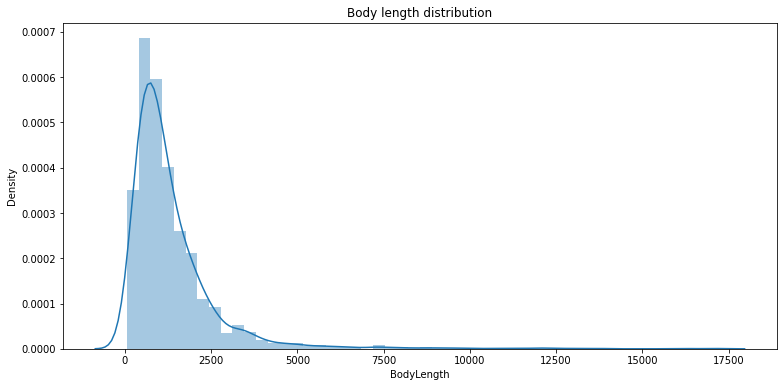

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns


df['BodyLength'] = df['Body'].str.len()

plt.figure(figsize=(12.8,6))
sns.distplot(df['BodyLength']).set_title('Body length distribution');

From the body length distribution plot, the majority of the questions body
has less than 5000 characters, so let's focus on the first 95% percentile.

/home/eduardo/PycharmProjects/DataMining/venv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


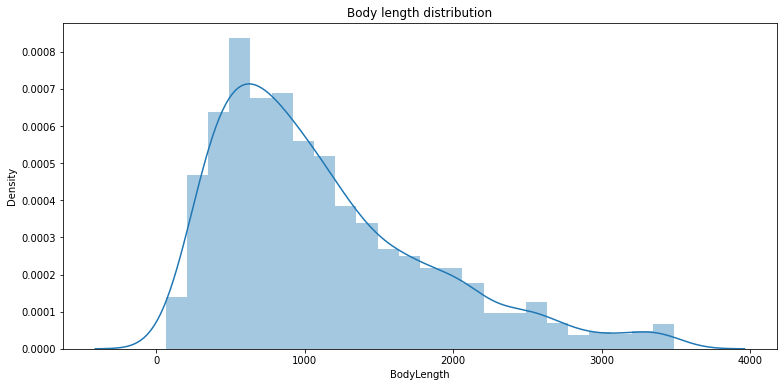

In [5]:
quantile_95 = df['BodyLength'].quantile(0.95)
df_95 = df[df['BodyLength'] < quantile_95]
plt.figure(figsize=(12.8,6))
sns.distplot(df_95['BodyLength']).set_title('Body length distribution');

In [6]:
## Text Cleaning


In [7]:
import re

# Multiple spaces Regex
SPACE_RE = re.compile(r'\s+')

# HTML Regex
HTML_RE = re.compile(r'<[^>]+>')

def clean_body(text):

    # Replace multiple spaces with single space
    text = SPACE_RE.sub(" ", text)

    # Remove HTML tags
    text = HTML_RE.sub("", text)

    # Removes new line character
    text = text.replace("\r", " ")    # Mac before OS X
    text = text.replace("\n", " ")    # Linux / Max OS X
    text = text.replace("\r\n", " ")  # Windows

    # Remove punctuation signs
    text = text.replace("?:!.,;", " ")

    # Remove all the special characters
    text = re.sub(r'\W', " ", text)

    # Remove possessive pronouns
    text = text.replace("'s", "")

    # Converting to Lowercase
    text = text.lower()

    return text


def clean_tags(text: str):
    # Remove opening tag character
    text = text.replace('<', "")

    # Crete a list of tags
    # using the closing tag character
    tags_list = text.split(">")

    return tuple(tags_list[:-1])

# Clean texts of the dataframe columns
df['Body'] = df['Body'].apply(clean_body)
df['Tags'] = df['Tags'].apply(clean_tags)

df.head(3)

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,...,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense,isPandas,BodyLength
0,33054527,1,33054552.0,NaN,2015-10-10 13:28:09,NaN,648,1269290,i ve very recently migrated to py 3 5 this co...,1656343.0,...,"TypeError: a bytes-like object is required, no...","(python, python-3.x, string, file, byte)",9,4,101.0,NaN,NaN,CC BY-SA 4.0,0,787
1,29846087,1,NaN,NaN,2015-04-24 11:16:44,NaN,271,772140,i ve installed python 3 5 and while running p...,268598.0,...,Microsoft Visual C++ 14.0 is required (Unable ...,"(python, python-3.x, visual-c++)",30,11,121.0,NaN,NaN,CC BY-SA 4.0,0,690
2,42339876,1,42340744.0,NaN,2017-02-20 08:43:18,NaN,187,629114,https github com affinelayer pix2pix tensorf...,7580060.0,...,error UnicodeDecodeError: 'utf-8' codec can't ...,"(python, python-3.x, utf-8)",17,0,41.0,NaN,NaN,CC BY-SA 3.0,0,1007


### Dealing with the categories list

Since there's hundreds of possible categories,
another query was created to fetch them from the database.

This dataset contains a single column with all categories
that appears on the the questions dataset.

The query can be found [here](https://data.stackexchange.com/stackoverflow/query/1320614/all-tags-used-with-python).


In [8]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


# Split the dataset into training and validation datasets
train_x, test_x, train_y, test_y = train_test_split(df["Body"], df["isPandas"], test_size=0.15)

# Label encode the target variable
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)

tfidf = TfidfVectorizer(analyzer='word', stop_words= 'english', max_features=500)

features_train = tfidf.fit_transform(train_x).toarray()
features_test = tfidf.fit_transform(test_x).toarray()

labels_train = train_y
labels_test = test_y

print(features_train.shape)
print(labels_test.shape)

(1700, 500)
(300,)


## Random Forest


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


rfc = RandomForestClassifier()

rfc.fit(features_train, labels_train)
rfc_pred = rfc.predict(features_test)

# Training accuracy
print("\nThe training accuracy is: ")
print(accuracy_score(labels_train, rfc.predict(features_train)))


# Test accuracy
print("\nThe test accuracy is: ")
print(accuracy_score(labels_test, rfc_pred))

# Classification report
print("\nClassification report")
print(classification_report(labels_test,rfc_pred))

print("\nConfusion matrix")
print(confusion_matrix(labels_test, rfc_pred))


The training accuracy is: 
1.0

The test accuracy is: 
0.55

Classification report
              precision    recall  f1-score   support

           0       0.53      0.86      0.65       147
           1       0.65      0.25      0.37       153

    accuracy                           0.55       300
   macro avg       0.59      0.56      0.51       300
weighted avg       0.59      0.55      0.51       300


Confusion matrix
[[126  21]
 [114  39]]


## Testing other hipper-parameters - Randomized Search Cross Validation

In [10]:
# Number of trees in the forest.
n_estimators = [x for x in range(0, 400, 5)]

# Max number of features considered for splitting a node
max_features = ['auto', 'sqrt']

# Max number of levels in each decision tree
max_depth = [x for x in range(1, 500, 5)]
max_depth.append(None)

# Min number of data points placed in a node before the node is split
min_samples_split = [2, 5, 10]

# Min number of data points allowed in a leaf node
min_samples_leaf = [1, 2, 4]

# Method for sampling data points (with or without replacement)
bootstrap = [True, False]

# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap,
}

### Performing the Random Search


In [11]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=random_grid,
    n_iter=50,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=8
)
# Fit the random search model
random_search.fit(features_train, labels_train)

# Show our best results
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
The best hyperparameters from Random Search are:
{'n_estimators': 345, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 121, 'bootstrap': True}

The mean accuracy of a model with these hyperparameters is:
0.9623543000064396


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  2.2min finished


In [12]:
best_rfc = random_search.best_estimator_
best_rfc_pred = best_rfc.predict(features_test)

# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_rfc.predict(features_train)))

# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, best_rfc_pred))

# Classification report
print("Classification report")
print(classification_report(labels_test, best_rfc_pred))

# Show confusion matrix
print("Confusion matrix")
print(confusion_matrix(labels_test, best_rfc_pred))

The training accuracy is: 
1.0
The test accuracy is: 
0.5666666666666667
Classification report
              precision    recall  f1-score   support

           0       0.54      0.86      0.66       147
           1       0.68      0.29      0.40       153

    accuracy                           0.57       300
   macro avg       0.61      0.57      0.53       300
weighted avg       0.61      0.57      0.53       300

Confusion matrix
[[126  21]
 [109  44]]


### Summary:

In [13]:
d = {
     'Model': 'Random Forest',
     'Training Set Accuracy': accuracy_score(labels_train, best_rfc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, best_rfc_pred)
}

df_models_rfc = pd.DataFrame(d, index=[0])
df_models_rfc


,Model,Training Set Accuracy,Test Set Accuracy
0,Random Forest,1.0,0.566667


## SVN
---

### Finding parameters

In [14]:
from sklearn import svm

# Find SVN parameters
svc_0 =svm.SVC(random_state=8)

print('Parameters currently in use:\n')
print(svc_0.get_params())

# Penalty parameter C of the error term
C = [.0001, .001, .01]

# Specifies the kernel type to be used in the algorithm.
kernel = ['linear', 'rbf', 'poly']

# Kernel coefficient
gamma = [.0001, .001, .01, .1, 1, 10, 100]

# Degree of the polynomial kernel function
degree = [1, 2, 3, 4, 5]

# probability
probability = [True, False]

# Create the random grid
random_grid = {
    'C': C,
    'kernel': kernel,
    'gamma': gamma,
    'degree': degree,
    'probability': probability,
}

Parameters currently in use:

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 8, 'shrinking': True, 'tol': 0.001, 'verbose': False}


### Random Search for SVN

In [15]:

# First create the base model to tune
svc = svm.SVC(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(
    estimator=svc,
    param_distributions=random_grid,
    n_iter=50,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=8
)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  6.4min finished


RandomizedSearchCV(cv=3, estimator=SVC(random_state=8), n_iter=50,
                   param_distributions={'C': [0.0001, 0.001, 0.01],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100],
                                        'kernel': ['linear', 'rbf', 'poly'],
                                        'probability': [True, False]},
                   random_state=8, scoring='accuracy', verbose=1)

### The best hyper-parameters are:

In [16]:
print("The best hyper-parameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

best_svc = random_search.best_estimator_

best_svc.fit(features_train, labels_train)
svc_pred = best_svc.predict(features_test)

# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_svc.predict(features_train)))

# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, svc_pred))

# Classification report
print("Classification report")
print(classification_report(labels_test, svc_pred))

The best hyper-parameters from Random Search are:
{'probability': True, 'kernel': 'poly', 'gamma': 100, 'degree': 2, 'C': 0.001}

The mean accuracy of a model with these hyperparameters is:
0.9129425010854143
The training accuracy is: 
0.9988235294117647
The test accuracy is: 
0.5833333333333334
Classification report
              precision    recall  f1-score   support

           0       0.55      0.84      0.66       147
           1       0.69      0.33      0.45       153

    accuracy                           0.58       300
   macro avg       0.62      0.59      0.56       300
weighted avg       0.62      0.58      0.55       300

